In [ ]:
#Install standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import os

In [ ]:
#Mount Google Collab
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Create path to data drive
import sys
sys.path.append('/content/drive/MyDrive/Google - Fast or Slow? Predict AI Model Runtime Predict how fast an AI model runs')

In [ ]:
# Function to plot histograms for 1D arrays
def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=30, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

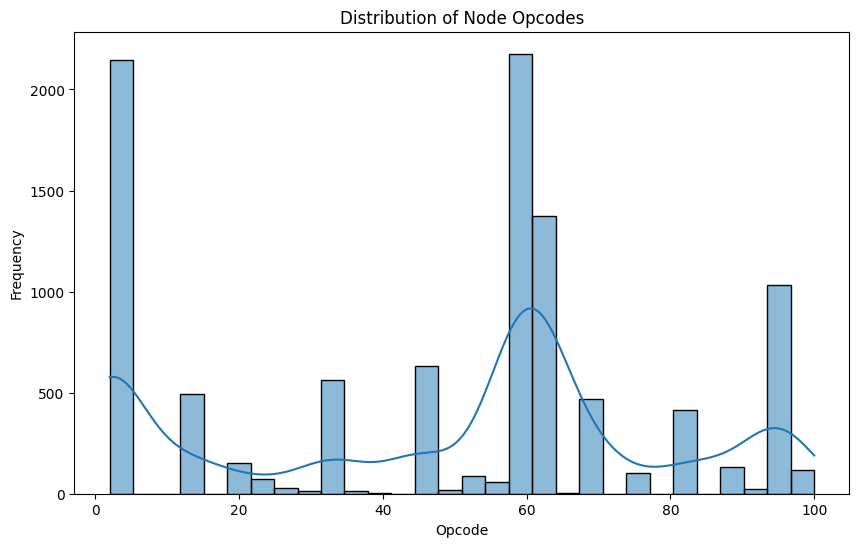

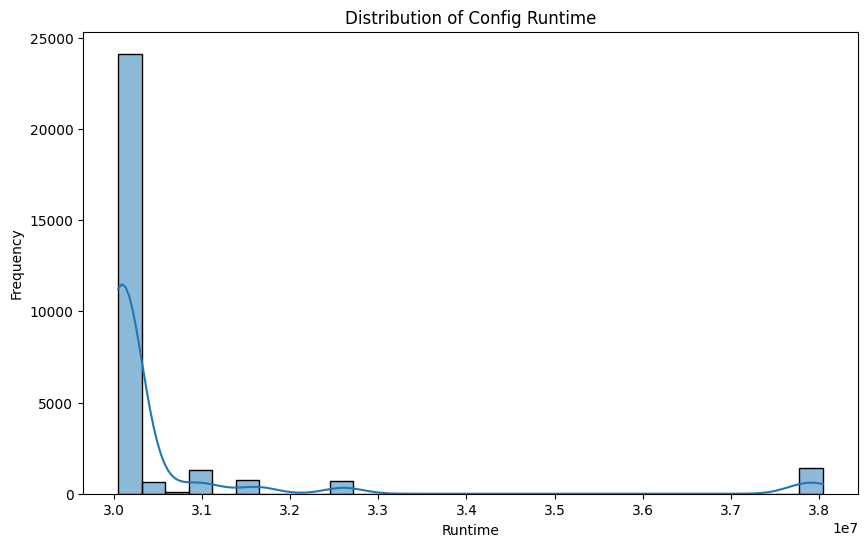

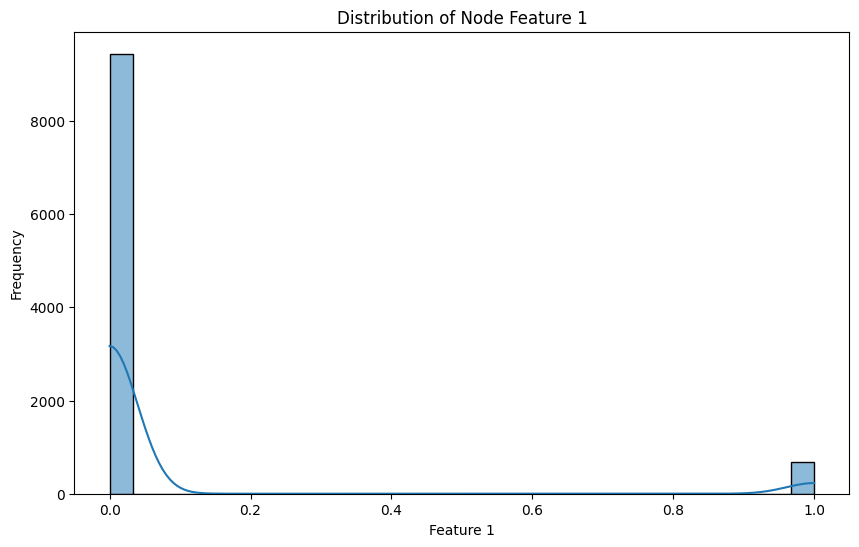

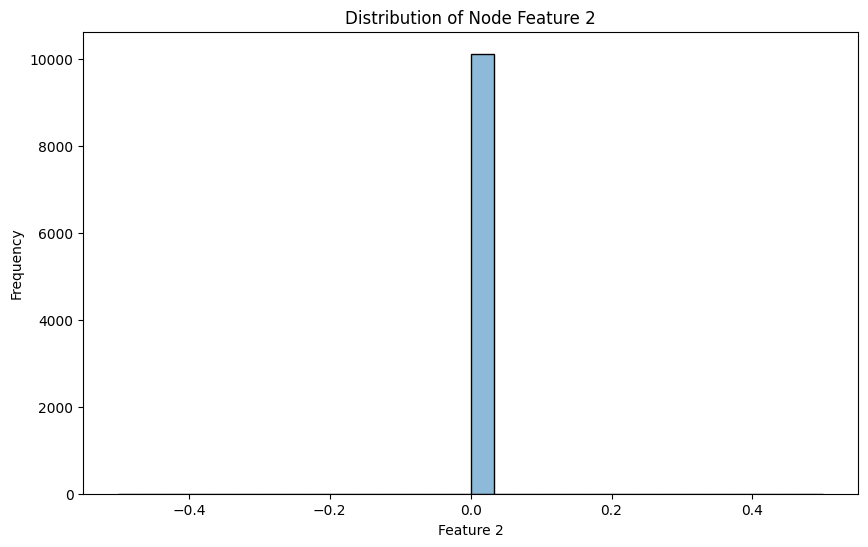

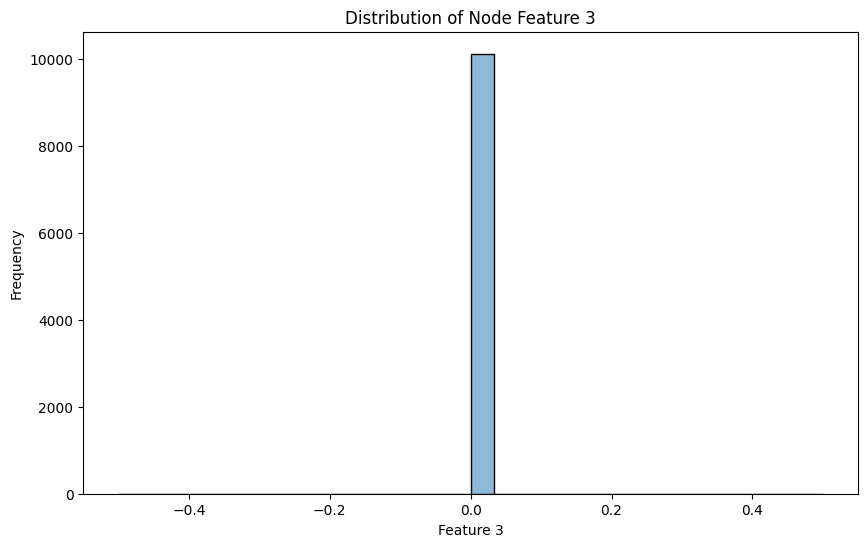

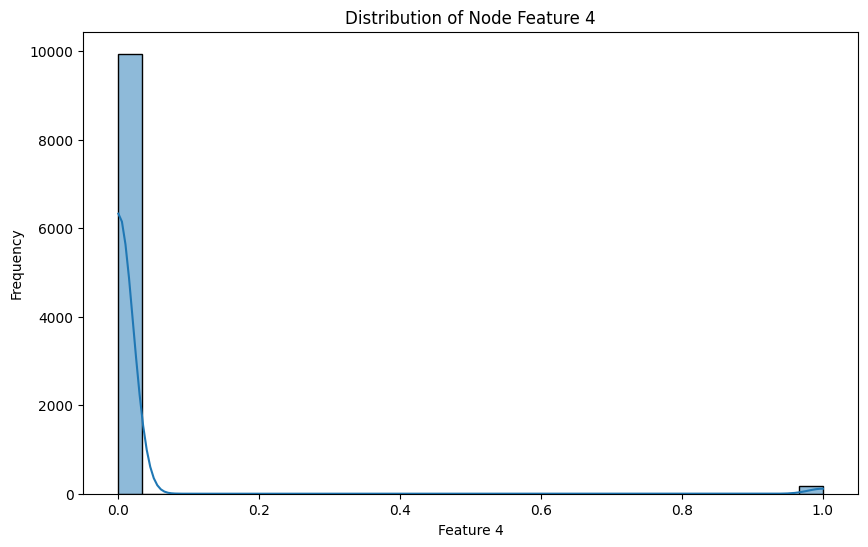

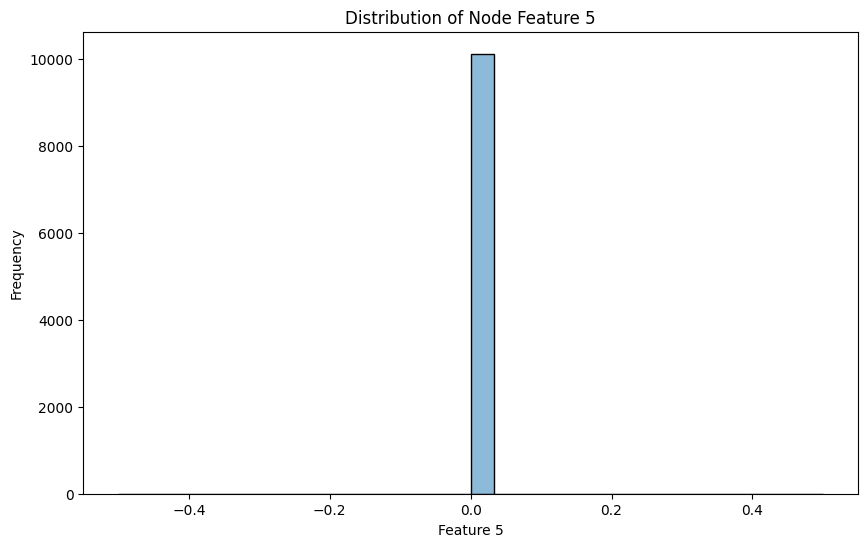

In [ ]:
# Load the .npz file
# electra_base_batch_size_16_train.npz
npz_file_path = '/content/drive/MyDrive/Google - Fast or Slow? Predict AI Model Runtime Predict how fast an AI model runs/data/tpugraphs/npz/layout/nlp/default/train/electra_base_batch_size_16_train.npz'
npz_data = np.load(npz_file_path)

# Plot histogram for node_opcode
plot_histogram(npz_data['node_opcode'], 'Distribution of Node Opcodes', 'Opcode', 'Frequency')

# Plot histogram for config_runtime
plot_histogram(npz_data['config_runtime'], 'Distribution of Config Runtime', 'Runtime', 'Frequency')

# Plot some sample histograms for node_feat (first 5 features)
for i in range(5):
    plot_histogram(npz_data['node_feat'][:, i], f'Distribution of Node Feature {i+1}', f'Feature {i+1}', 'Frequency')

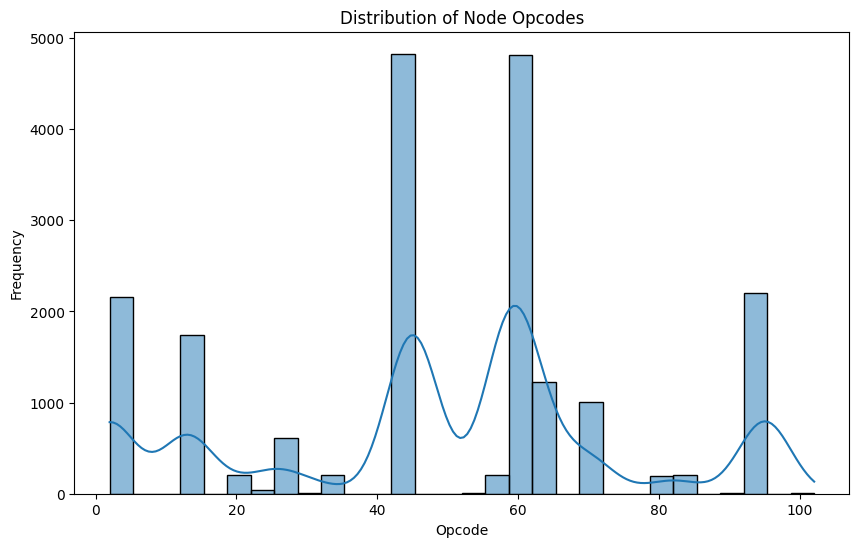

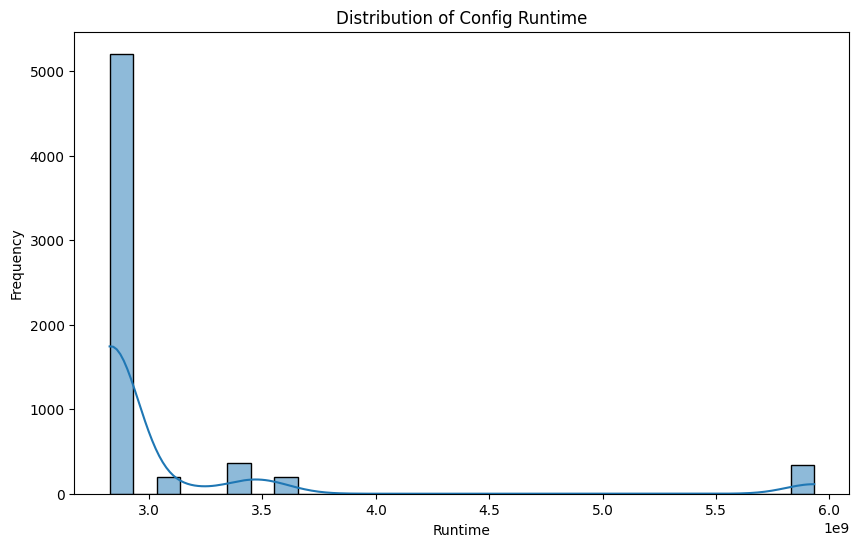

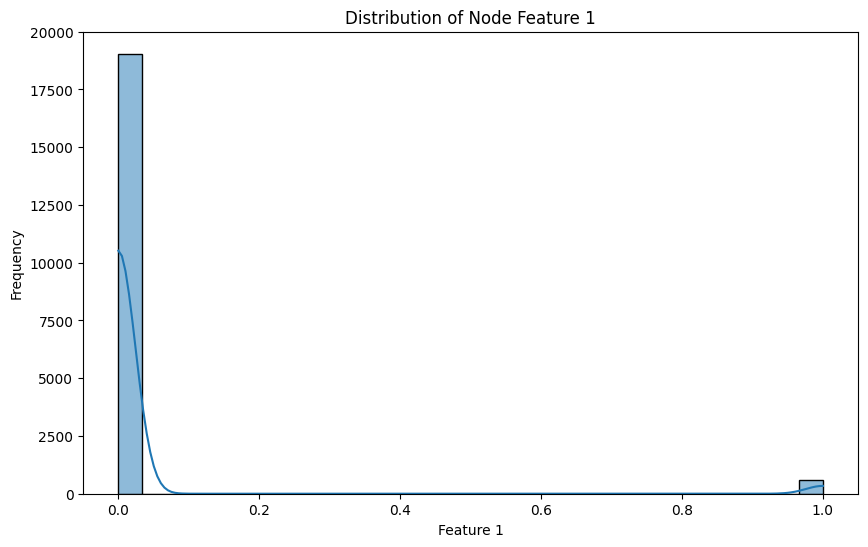

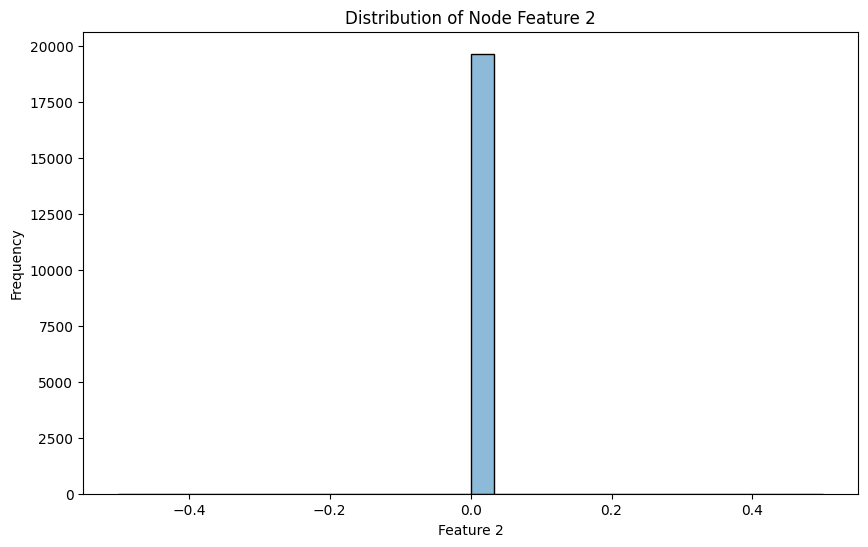

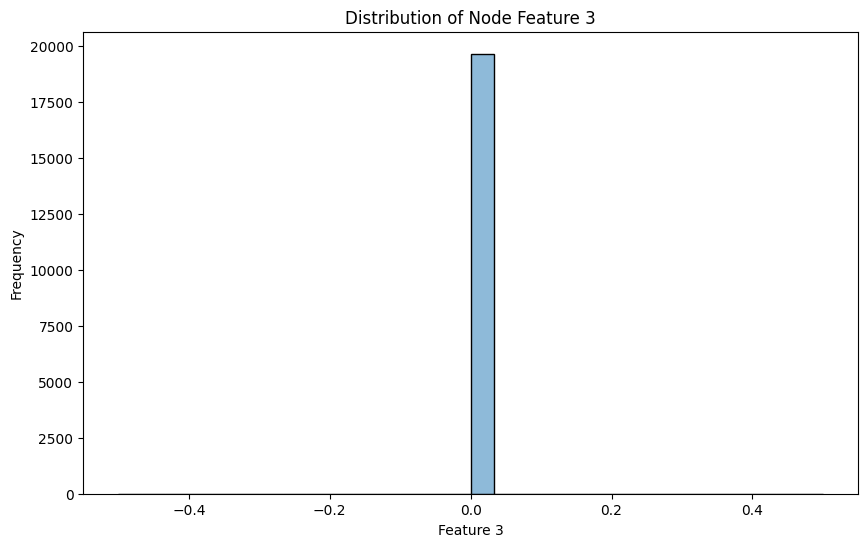

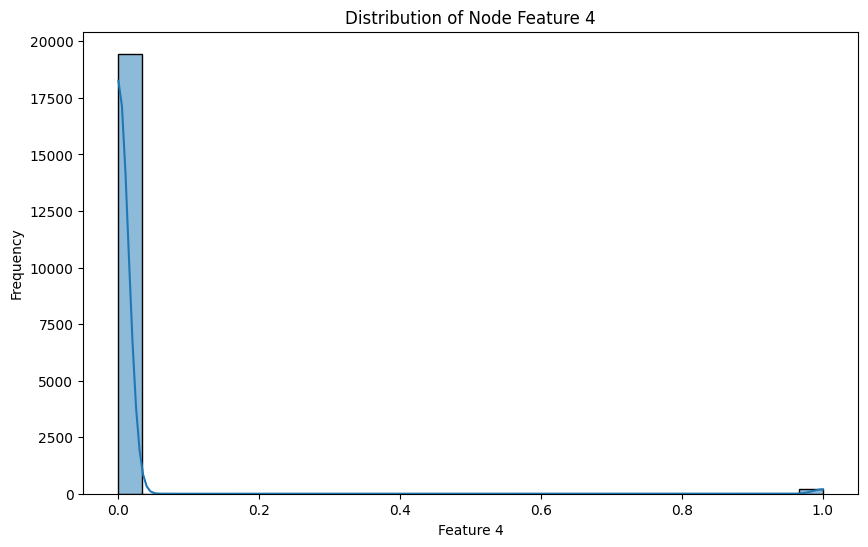

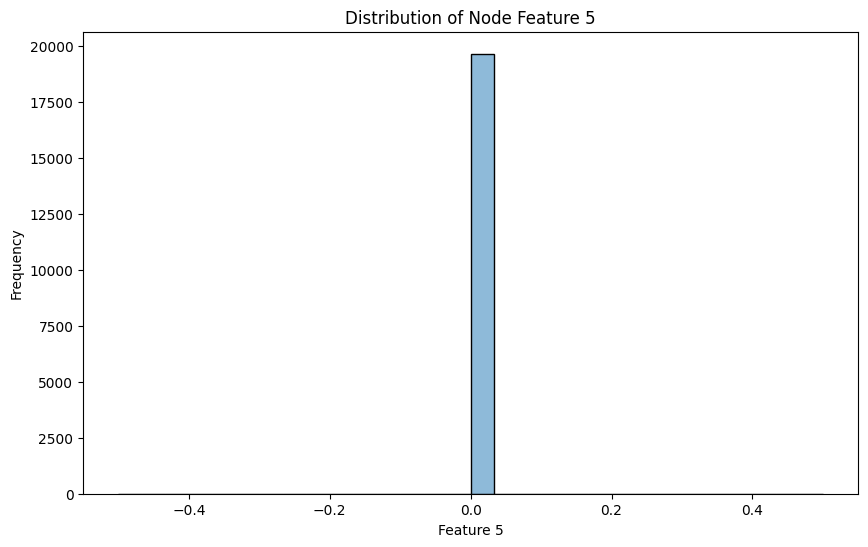

In [ ]:
# Load the .npz file
npz_file_path = '/content/drive/MyDrive/Google - Fast or Slow? Predict AI Model Runtime Predict how fast an AI model runs/data/tpugraphs/npz/layout/xla/default/train/resnet_v2_200_batch_64.npz'
npz_data = np.load(npz_file_path)

# Plot histogram for node_opcode
plot_histogram(npz_data['node_opcode'], 'Distribution of Node Opcodes', 'Opcode', 'Frequency')

# Plot histogram for config_runtime
plot_histogram(npz_data['config_runtime'], 'Distribution of Config Runtime', 'Runtime', 'Frequency')

# Plot some sample histograms for node_feat (first 5 features)
for i in range(5):
    plot_histogram(npz_data['node_feat'][:, i], f'Distribution of Node Feature {i+1}', f'Feature {i+1}', 'Frequency')

In [ ]:
!pip install torch-geometric torch-scatter

  Using cached torch_geometric-2.3.1-py3-none-any.whl
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=494366 sha256=1c003ef1c170bd758fbec4d63150ed75a47760b833170f37cc0b7459b5100da1
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter


In [ ]:
# Model imports
import torch
from torch import nn
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch.utils.data import DataLoader, Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# We can load all the data in the dataframes to make working with it easier
def load_df(directory):
    splits = ["train", "valid", "test"]
    dfs = dict()

    for split in splits:
        path = os.path.join(directory, split)
        files = os.listdir(path)
        list_df = []

        for file in files:
            d = dict(np.load(os.path.join(path,file)))
            d['file'] = file
            list_df.append(d)
        dfs[split] = pd.DataFrame.from_dict(list_df)
    return dfs

In [ ]:
tile_xla = load_df("/content/drive/MyDrive/Google - Fast or Slow? Predict AI Model Runtime Predict how fast an AI model runs/data/tpugraphs/npz/tile/xla")

In [ ]:
# Define dataset and Model

class TileDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        config_feat = torch.tensor(row['config_feat'].astype(np.float32))
        node_feat = torch.tensor(row['node_feat'].astype(np.float32))
        node_opcode = torch.tensor(row['node_opcode'].astype(np.int32))
        edge_index = torch.tensor(np.swapaxes(row['edge_index'],0,1).astype(np.int32))
        target = (row['config_runtime']/row['config_runtime_normalizers']).astype(np.float32)
        # minmax scale the target, we only care about order
        target = (target-min(target))/(max(target) -min(target))
        target = torch.tensor(target)
        return config_feat,node_feat,node_opcode,edge_index,target

In [ ]:
class SimpleModel(torch.nn.Module):
    def __init__(self, hidden_channels, graph_feats, hidden_dim):
        super().__init__()
        op_embedding_dim = 4 # I choose 4-dimensional embedding
        self.embedding = torch.nn.Embedding(120, #120 different op-codes
                                            op_embedding_dim,
                                           )
        assert len(hidden_channels)>0
        in_channels = op_embedding_dim+140
        self.convs = torch.nn.ModuleList()
        last_dim = hidden_channels[0]
        self.convs.append(GCNConv(in_channels, hidden_channels[0]))
        for i in range(len(hidden_channels)-1):
            self.convs.append(GCNConv(hidden_channels[i], hidden_channels[i+1]))
            last_dim = hidden_channels[i+1]
        self.convs.append(GCNConv(last_dim, graph_feats))

        self.dense = torch.nn.Sequential(nn.Linear(graph_feats+24, 64),
                                         nn.ReLU(),
                                         nn.Linear(64, 64),
                                         nn.ReLU(),
                                         nn.Linear(64, 1),
                                        )

    def forward(self, x_cfg: Tensor,x_feat: Tensor, x_op: Tensor, edge_index: Tensor) -> Tensor:

        #get graph features
        x = torch.concat([x_feat,self.embedding(x_op)],dim = 1)
        #pass though conv layers
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        # get 1d graph embedding using average pooling
        x_graph = torch.mean(x,0)


        #put graph data into config data
        x = torch.concat([x_cfg,x_graph.repeat((len(x_cfg),1))],axis=1)
        #put into dense nn
        x = torch.flatten(self.dense(x))
        return x

model = SimpleModel(hidden_channels = [16,32,16,48],graph_feats = 64,hidden_dim=64).to(device)

In [ ]:
# Lets train one epoch

dataset = TileDataset(tile_xla["train"])
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay = 0.01)

model.train()
pbar = tqdm(range(len(dataset)))
loss_sum = 0
n = 0
for i in pbar:
    cfg_ft,nd_ft,nd_op,ind,target = dataset[i]
    cfg_ft,nd_ft,nd_op,ind,target = cfg_ft.to(device),nd_ft.to(device),nd_op.to(device),ind.to(device),target.to(device)

    out = model(cfg_ft,nd_ft,nd_op,ind)
    loss = criterion(out, target)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
    optimizer.step()

    loss_sum+=loss.item()
    n+=1
    pbar.set_description(f'running loss: {(loss_sum/n):.1f},current loss: {(loss.item()):.1f}')

running loss: 1.7,current loss: 0.1: 100%|██████████| 5728/5728 [06:03<00:00, 15.76it/s]


In [ ]:
# Evaluate on validation dataset

dataset = TileDataset(tile_xla["valid"])
tile_xla_predictions = []
model.eval()

pbar = tqdm(range(len(dataset)))
for i in pbar:
    cfg_ft,nd_ft,nd_op,ind,target = dataset[i]
    cfg_ft,nd_ft,nd_op,ind,target = cfg_ft.to(device),nd_ft.to(device),nd_op.to(device),ind.to(device),target.to(device)

    out = model(cfg_ft,nd_ft,nd_op,ind)
    tile_xla_predictions.append(np.argsort(out.detach().numpy())[:5])

def score_tile(predictions, df):
    score = 0
    for i in range(len(df)):
        predbest = min(df.iloc[i]['config_runtime'][predictions[i]])
        best = min(df.iloc[i]['config_runtime'])
        score +=2 - predbest/best
    score /= len(df)
    return score
score_tile(tile_xla_predictions, tile_xla["valid"])

100%|██████████| 676/676 [00:07<00:00, 87.56it/s]


0.3068444766531606

In [ ]:
# Predict (only tile:xla predictions)

dataset = TileDataset(tile_xla["test"])
tile_xla_predictions = []
model.eval()
pbar = tqdm(range(len(dataset)))
for i in pbar:
    cfg_ft,nd_ft,nd_op,ind,target = dataset[i]
    cfg_ft,nd_ft,nd_op,ind,target = cfg_ft.to(device),nd_ft.to(device),nd_op.to(device),ind.to(device),target.to(device)

    out = model(cfg_ft,nd_ft,nd_op,ind)
    tile_xla_predictions.append(np.argsort(out.detach().numpy())[:5])

  0%|          | 0/844 [00:00<?, ?it/s]<ipython-input-11-bbbede27aa7e>:18: RuntimeWarning: invalid value encountered in divide
  target = (target-min(target))/(max(target) -min(target))
100%|██████████| 844/844 [00:10<00:00, 78.27it/s] 
